In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=100000)

In [4]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [5]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [6]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [7]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [8]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [9]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [10]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [11]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-11-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.003479
3,2022-03-31 00:11:31,111,IMO0000001,27.35380,-94.62557,0.3,105.0,-456.333529,-5640.203881,2927.370986,0.022308
4,2022-03-31 00:14:33,111,IMO0000001,27.35365,-94.62542,0.3,173.4,-456.319381,-5640.212715,2927.356172,0.002224


In [12]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [13]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-13-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950,NaN
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126,183.0
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.003479,179.0
3,2022-03-31 00:11:31,111,IMO0000001,27.35380,-94.62557,0.3,105.0,-456.333529,-5640.203881,2927.370986,0.022308,177.0
4,2022-03-31 00:14:33,111,IMO0000001,27.35365,-94.62542,0.3,173.4,-456.319381,-5640.212715,2927.356172,0.002224,182.0


In [14]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [15]:
import pandas as pd
import numpy as np

# Define the function to calculate magnitude
def calculate_magnitude(df):
    # Calculate the velocity components
    df['v_x'] = df['sog_mps'] * np.cos(df['cog_radians'])
    df['v_y'] = df['sog_mps'] * np.sin(df['cog_radians'])

    # Calculate the magnitude
    df['magnitude'] = np.sqrt(df['v_x']**2 + df['v_y']**2)

    # Drop the v_x and v_y columns
    df.drop(columns=['v_x', 'v_y'], inplace=True)

    return df

# Apply the function
df = calculate_magnitude(df)


In [16]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds,sog_mps,cog_radians,magnitude
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950,NaN,0.205778,3.989823,0.205778
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126,183.0,0.308666,3.836234,0.308666
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.003479,179.0,0.102889,3.869395,0.102889
3,2022-03-31 00:11:31,111,IMO0000001,27.35380,-94.62557,0.3,105.0,-456.333529,-5640.203881,2927.370986,0.022308,177.0,0.154333,1.832596,0.154333
4,2022-03-31 00:14:33,111,IMO0000001,27.35365,-94.62542,0.3,173.4,-456.319381,-5640.212715,2927.356172,0.002224,182.0,0.154333,3.026401,0.154333


In [17]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians',
         'magnitude']]

In [18]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians,magnitude
0,-456.323030,-5640.208831,2927.363085,NaN,0.003950,0.205778,3.989823,0.205778
1,-456.326968,-5640.208513,2927.363085,183.0,0.008126,0.308666,3.836234,0.308666
2,-456.332668,-5640.205489,2927.368023,179.0,0.003479,0.102889,3.869395,0.102889
3,-456.333529,-5640.203881,2927.370986,177.0,0.022308,0.154333,1.832596,0.154333
4,-456.319381,-5640.212715,2927.356172,182.0,0.002224,0.154333,3.026401,0.154333


In [19]:
df.dropna(inplace=True)

In [20]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians,magnitude
1,-456.326968,-5640.208513,2927.363085,183.0,0.008126,0.308666,3.836234,0.308666
2,-456.332668,-5640.205489,2927.368023,179.0,0.003479,0.102889,3.869395,0.102889
3,-456.333529,-5640.203881,2927.370986,177.0,0.022308,0.154333,1.832596,0.154333
4,-456.319381,-5640.212715,2927.356172,182.0,0.002224,0.154333,3.026401,0.154333
5,-456.319299,-5640.211696,2927.358147,180.0,0.013191,0.205778,4.204498,0.205778


In [21]:
# def causal_attention_mask(batch_size, seq_length):
#     mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)  # Upper triangular mask
#     mask = tf.reshape(mask, (1, 1, seq_length, seq_length))  # Expand dims for multi-head attention
#     return tf.tile(mask, [batch_size, 1, 1, 1])  # Tile across the batch


In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
    TimeDistributed, Embedding
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


# Normalize Data
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)


# Ensure feature dimensions are even (remove unnecessary padding)
if scaled_train.shape[1] % 2 != 0:
    scaled_train = np.hstack([scaled_train, np.zeros((scaled_train.shape[0], 1))])
    scaled_test = np.hstack([scaled_test, np.zeros((scaled_test.shape[0], 1))])

# Learned Start Token (Use a trainable variable instead of Embedding)
start_token_layer = tf.Variable(tf.random.normal((1, df.shape[1])), trainable=True)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def build(self, input_shape):
        seq_len, d_model = input_shape[1], input_shape[2]

        pos = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))

        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)

        self.pe = self.add_weight(
            shape=(1, seq_len, d_model),
            initializer=tf.keras.initializers.Constant(pe),
            trainable=False
        )

    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]

def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []
    for i in range(len(data) - 2*seq_length + 1):  # Adjusted loop range
        # Encoder input: current window
        X.append(data[i:i+seq_length])

        # Start token = last element of encoder input
        start_token = data[i+seq_length-1]

        # Decoder input: Start token + shifted targets (teacher forcing)
        decoder_in = np.vstack([
            start_token,  # Start token
            data[i+seq_length:i+seq_length+seq_length-1]  # Shifted target values (teacher forcing)
        ])

        # Target: Future sequence (same as shifted targets in decoder input)
        decoder_target = data[i+seq_length:i+seq_length+seq_length]

        decoder_inputs.append(decoder_in)
        decoder_targets.append(decoder_target)

    return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)


seq_length = 10  # Time window
X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
    attention = Dropout(dropout_rate)(attention)
    attention = inputs + attention
    attention = LayerNormalization(epsilon=1e-6)(attention)

    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention + ff_output)


def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    # Generate causal mask using a Lambda layer
    causal_mask = tf.keras.layers.Lambda(
        lambda x: tf.tile(
            tf.reshape(
                tf.linalg.band_part(tf.ones((tf.shape(x)[1], tf.shape(x)[1])), -1, 0),
                (1, 1, tf.shape(x)[1], tf.shape(x)[1])
            ),
            [tf.shape(x)[0], 1, 1, 1]
        )
    )(inputs)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        attention_norm, attention_norm, attention_mask=causal_mask
    )
    attention1 = Dropout(dropout_rate)(attention1)
    attention1 = inputs + attention1
    attention1 = LayerNormalization(epsilon=1e-6)(attention1)

    # Project encoder outputs for better integration
    encoder_projection = Dense(input_dim)(encoder_outputs)

    # Cross-attention between decoder and encoder outputs
    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        query=attention1, key=encoder_projection, value=encoder_projection
    )
    attention2 = Dropout(dropout_rate)(attention2)
    attention2 = attention1 + attention2
    attention2 = LayerNormalization(epsilon=1e-6)(attention2)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation="relu")(attention2)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)

def build_transformer_model(input_shape, target_shape):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    x = PositionalEncoding()(encoder_inputs)
    encoder_outputs = transformer_encoder(x)

    decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
    x = PositionalEncoding()(decoder_inputs)
    decoder_outputs = transformer_decoder(x, encoder_outputs)

    x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
    outputs = TimeDistributed(Dense(target_shape[-1]))(x)

    return Model([encoder_inputs, decoder_inputs], outputs)

model = build_transformer_model(
    (seq_length, scaled_train.shape[1]),
    (seq_length, scaled_train.shape[1])
)

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
model.summary()

# Train model
model.fit(
    [X_train, decoder_inputs_train], decoder_targets_train,
    validation_data=([X_test, decoder_inputs_test], decoder_targets_test),
    epochs=20, batch_size=32
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding       │ (None, 10, 8)          │             80 │ encoder_inputs[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 10, 8)          │             16 │ positional_encoding[0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 10, 8)          │            288 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 10, 8)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 8)          │              0 │ positional_encoding[0… │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 10, 8)          │             16 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_1     │ (None, 10, 8)          │             80 │ decoder_inputs[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 64)         │            576 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 10, 8)          │             16 │ positional_encoding_1… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1, 10, 10)      │              0 │ positional_encoding_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10, 8)          │            520 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 10, 8)          │            288 │ layer_normalization_3… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_3… │
│                           │                        │                │ lambda[0][0]           │
├──────────────────────

 Total params: 3,952 (15.44 KB)

 Trainable params: 3,792 (14.81 KB)

 Non-trainable params: 160 (640.00 B)

Epoch 1/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - accuracy: 0.6010 - loss: 0.0457 - val_accuracy: 0.8024 - val_loss: 0.0085
Epoch 2/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.8094 - loss: 0.0081 - val_accuracy: 0.8462 - val_loss: 0.0066
Epoch 3/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 73s 17ms/step - accuracy: 0.8319 - loss: 0.0065 - val_accuracy: 0.8437 - val_loss: 0.0063
Epoch 4/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.8376 - loss: 0.0061 - val_accuracy: 0.8325 - val_loss: 0.0060
Epoch 5/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 79s 17ms/step - accuracy: 0.8401 - loss: 0.0059 - val_accuracy: 0.8384 - val_loss: 0.0059
Epoch 6/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - accuracy: 0.8448 - loss: 0.0057 - val_accuracy: 0.8564 - val_loss: 0.0058
Epoch 7/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - accuracy: 0.8456 - loss: 0.0056 - val_accuracy: 0.8536 - val_loss: 0.0057
Epoch 8/20
2423/2423 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - accuracy: 0.8476 -

In [25]:
model.save_weights('transformer_model_weights.weights.h5')

In [ ]:
# future_steps = 20
# future_predictions = []

# # Initialize input sequence (keep encoder input fixed)
# encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])

# # Initialize decoder input with a start token (can be zeros or last known value)
# decoder_input = np.zeros((1, seq_length, X_train.shape[2]))

# for step in range(future_steps):
#     # Predict next step
#     pred = model.predict([encoder_input, decoder_input], verbose=0)

#     # Extract last predicted time step
#     next_pred = pred[0, -1, :]

#     # Store prediction
#     future_predictions.append(next_pred)

#     # Shift decoder input and insert new prediction
#     decoder_input = np.roll(decoder_input, -1, axis=1)
#     decoder_input[0, -1, :] = next_pred  # Insert new prediction at last timestep

# # Convert to NumPy array
# future_predictions = np.array(future_predictions)

# # Convert predictions back to original scale
# future_predictions = scaler.inverse_transform(future_predictions)

# #  Ensure column count matches predictions
# expected_columns = df.columns[:future_predictions.shape[1]]  # Select the correct number of columns

# # Create timestamps for predicted values
# forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# # 🔹 Plot Actual vs. Predicted Values
# plt.figure(figsize=(10, 5))
# plt.plot(df["y"], label="Actual y", color="blue")
# plt.plot(forecast_df["y"], label="Predicted y", color="red", linestyle="dashed")
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Value")
# plt.title("Future Predictions")
# plt.grid()
# plt.show()


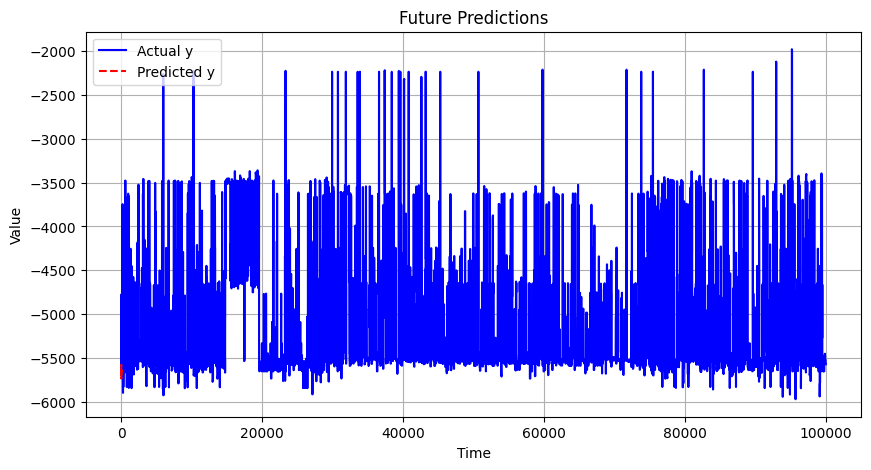

In [26]:
future_steps = 20
future_predictions = []

# Initialize input sequence (keep encoder input fixed)
encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])

# Initialize decoder input with a start token (can be zeros or last known value)
decoder_input = np.zeros((1, seq_length, X_train.shape[2]))

# Apply positional encoding to the inputs (same as during training)
encoder_input_pos_encoded = PositionalEncoding()(encoder_input)
decoder_input_pos_encoded = PositionalEncoding()(decoder_input)

for step in range(future_steps):
    # Predict next step
    pred = model.predict([encoder_input_pos_encoded, decoder_input_pos_encoded], verbose=0)

    # Extract last predicted time step
    next_pred = pred[0, -1, :]

    # Store prediction
    future_predictions.append(next_pred)

    # Shift decoder input and insert new prediction
    decoder_input = np.roll(decoder_input, -1, axis=1)
    decoder_input[0, -1, :] = next_pred  # Insert new prediction at last timestep

    # Apply positional encoding again to the updated decoder input
    decoder_input_pos_encoded = PositionalEncoding()(decoder_input)

# Convert to NumPy array
future_predictions = np.array(future_predictions)

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Ensure column count matches predictions
expected_columns = df.columns[:future_predictions.shape[1]]  # Select the correct number of columns

# Create timestamps for predicted values
forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# 🔹 Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(df["y"], label="Actual y", color="blue")
plt.plot(forecast_df["y"], label="Predicted y", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()
